# **Library imports**

In [ ]:
kaggle = False # @param {"type":"boolean"}
colabenv = True # @param {"type":"boolean"}
import gdown
import zipfile
import os
if kaggle:
  if not os.path.exists("/kaggle/working/MOR_data2.zip"):
    !gdown --id 11Ux8SX7jC-4vbpotUc_rrpIqpJd_jFDx
  with zipfile.ZipFile("/kaggle/working/MOR_data2.zip", 'r') as zip_ref:
    zip_ref.extractall("/kaggle/working")

  os.chdir('MOR_data2')

In [ ]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

if colabenv:
  from google.colab import files, drive
  drive.mount('/content/drive')

  import os
  os.chdir('/content/drive/MyDrive/MOR_data2')

import numpy as np
import torch
from torch.optim import Adam
from time import perf_counter
from scipy.linalg import svd
# %cd /kaggle/working/

Mounted at /content/drive


## **Fisher-KPP equation**: damage propagation in a U-bolt

# **Problem Setup**

In [ ]:
# FOM discretization
import gdown
if not os.path.exists("ubolt_mesh.xml"):
  gdown.download(id = "1_4uC_yjWmvaDfAuRt0I1PI3IENE4XYXX", output = "ubolt_mesh.xml")

mesh = fe.loadmesh("ubolt_mesh.xml")
Vh = fe.space(mesh, 'CG', 1)
clc()

if not os.path.exists("ubolt.npz"):
  # Dataset (parameters and FKPP simulations)
  gdown.download(id = "1ehojde4rL-8-zoyiKikes3e76CpPvJzC", output = "ubolt.npz")
  clc()

dataset = np.load("ubolt.npz")
mu, u = dataset['mu'], dataset['u']

### verify loaded dataset

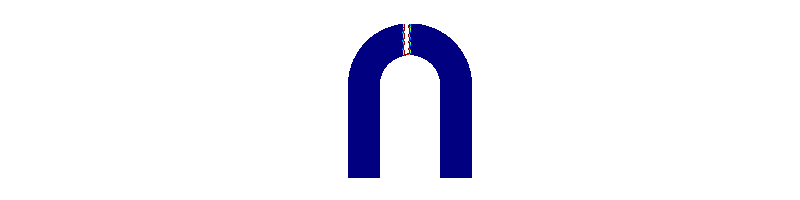

In [ ]:
# visualization to check everything's working
def visualize(uexample):
    fe.animate(uexample[::5], Vh, figsize = (8, 2))

visualize(u[20])

## **pre-processing**

In [ ]:
# load the mu and u as tensors instead of numpy (utilize GPU)
mu, u = dv.tensor(dataset['mu']), dv.tensor(dataset['u'])

ndata, ntimes, nh = u.shape
p = mu.shape[-1]
print("Trajectories:\t%d." % ndata)
print("Timesteps:\t%d." % ntimes)
print("FOM dimension:\t%d." % nh)
print("Parameters:\t%d." % p)

# loop to add time as parameter in mu
mut = dv.zeros(ndata, ntimes, p+1)
times = dv.tensor(np.linspace(0, 0.02, ntimes))
for i in range(ndata):
    mut[i,:,:p] = mu[i]
    mut[i,:, p] = times


print(f"u shape: {u.shape}")
print(f"mut shape: {mut.shape}")

print("reshaping u and mut...")
# resize the u and mu to be consistent with each sample is for a given parameters mu[0:3] and time step mut[3]
u = u.reshape(-1, nh)
mut = mut.reshape(-1, p+1)

print(f"u shape: {u.shape}")
print(f"mut shape: {mut.shape}")

Trajectories:	100.
Timesteps:	41.
FOM dimension:	6636.
Parameters:	3.
u shape: torch.Size([100, 41, 6636])
mut shape: torch.Size([100, 41, 4])
reshaping u and mut...
u shape: torch.Size([4100, 6636])
mut shape: torch.Size([4100, 4])


# **Part i) & ii)**

# **POD-NN**

## **Pre-processing and basis vector extraction**

In [ ]:
# Data pre-processing
# split the data into training and testing sets
split = 75
ntrain = split*ntimes
u_train = u[:ntrain].reshape(-1, nh)
mut_train = mut[:ntrain].reshape(-1, p+1)

print(f"u_train shape: {u_train.shape}")
print(f"mut_train shape: {mut_train.shape}")

u_train shape: torch.Size([3075, 6636])
mut_train shape: torch.Size([3075, 4])


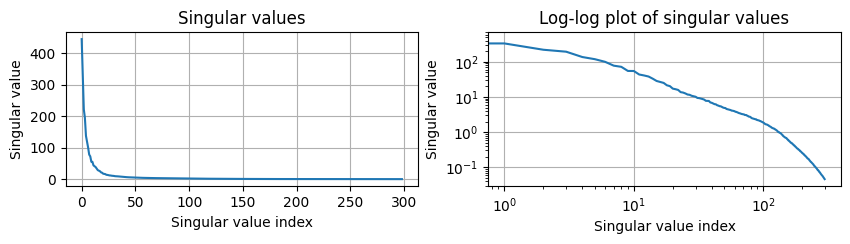

In [ ]:
# extraction of singular values to check the decay
X, s, _ = svd(u_train.T.cpu().numpy(), full_matrices = False)

plt.figure(figsize = (10, 2))
plt.subplot(1, 2, 1)
plt.plot(s[1:300]), plt.title("Singular values")
plt.xlabel("Singular value index"), plt.ylabel("Singular value")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.loglog(s[1:300]), plt.title("Log-log plot of singular values")
plt.xlabel("Singular value index"), plt.ylabel("Singular value")
plt.grid(True)
plt.show()

In [ ]:
# check if cuda is available for usage
if torch.cuda.is_available():
    print("CUDA is available!")
    cuda = True
else:
    print("CUDA not available")
    cuda = False

if cuda: # check for cuda
  u = u.cpu()

energy = np.cumsum(s**2) / np.sum(s**2)
n = np.searchsorted(energy, 0.9999) + 1  # +1 because indices start at 0
print(f"Number of modes for 99.99% energy: {n}")

n = int(n)
V = X[:, :n]
# V = dv.tensor(V)
# looking at u and V sizes
print(f"V is:{V.shape}")
print(f"u is:{u.numpy().shape}")


uproj = u.numpy() @ V @ V.T
avg_proj_error = mre(euclidean)(u[ntrain:], uproj[ntrain:])
print("Average projection error: %s." % num2p(avg_proj_error))

CUDA not available
Number of modes for 99.99% energy: 80
V is:(6636, 80)
u is:(4100, 6636)
Average projection error: 1.41%.


### ***side note***: a look at the basis functions visually

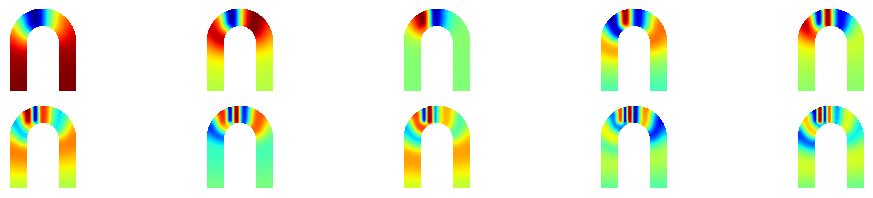

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(10):
  V0 = fe.asfunction(V[:,i],Vh)
  plt.subplot(5,5,i+1)
  fe.plot(V0)

plt.tight_layout()
plt.show()

### *option 2*: use projection error to pick r

In [ ]:
errorList = []
# in this loop the projection error was stored to analyze the decay
for r in range(1, 200):
  V = X[:, :r]
  # Projection error analysis
  uproj = u.numpy() @ V @ V.T
  errors = mre(euclidean)(u[ntrain:], uproj[ntrain:])
  errorList.append(errors)

/tmp/ipython-input-80-771791675.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  uproj = u @ V @ V.T


([<matplotlib.lines.Line2D at 0x7ae122987710>],
 Text(0.5, 1.0, 'Log Scale'),
 None)

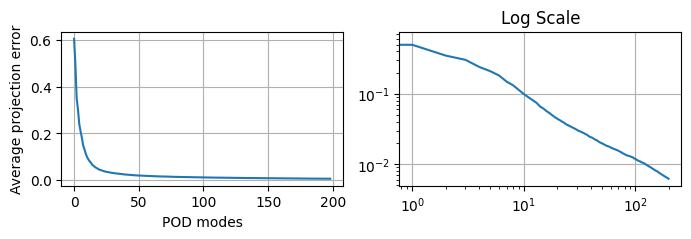

In [ ]:
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(errorList), plt.grid(True)
plt.xlabel("POD modes")
plt.ylabel("Average projection error")

plt.subplot(1, 2, 2)
plt.loglog(errorList), plt.title("Log Scale"), plt.grid(True)

note: not very fast decay rate of projection error

In [ ]:
# use a pre-specified average error and choose r based on that
AvgErr = 0.66 #percent
errorArray = np.array(errorList)
indices = np.where(errorArray <= AvgErr/100 )[0]
r = indices[0]
print(f"r: {r}")
V = X[:, :r]

r: 187


note: looking at the decay of projection error we can see around 100 basis almost good enough and for further decrease of error we need to add way more basis vectors as it can be seen for 0.66% error it jumps to another 87 basis vecors.

we proceed with 80 as it captures the 99.99% of the energy based on sigular value decay rate.

## **Model Training/Load**

In [ ]:
# use Adam for optimization
c = u @ V
print(f"c shape: {c.shape}")
''' @param {"type":"boolean"}'''
load_pretrained = True # @param {"type":"boolean"}
retrain = False # @param {"type":"boolean"}

if load_pretrained:

    phi = Dense(p+1, 32, gelu) + Dense(32, 64, gelu) + Dense(64, n, activation = None)
    model = DFNN(phi)
    model.He()

    # At this point, `loaded_model` has fresh, randomly initialized weights.

    # --- 2. Load the saved weights from the file ---
    MODEL_SAVE_PATH_state_dict = "my_dfnn_model_state_dict4-82.pth"
    model.load_state_dict(torch.load(MODEL_SAVE_PATH_state_dict,weights_only=False))

    # %cd /kaggle/input/model_podnn_adam_l2_4p9/pytorch/default/1
    # model = torch.load('model_PODNN_adam_L2_4p9.pth',weights_only=False)
    print("Model loaded from pretrained weights.")
    print(model)
    model.freeze()
    if retrain:
        model.unfreeze()
        model.train(mut, c, ntrain = ntrain, epochs = 300, loss = mse(euclidean), notation = '%')
        model.train(mut, c, ntrain = ntrain, epochs = 1000, loss = mse(euclidean),
                        optim = Adam, lr = 1e-5, batchsize = 512, notation = '%')
        model.freeze()

if not load_pretrained and not retrain: # if not load_pretrained
    # define the neural network architecture and train it
    phi = Dense(p+1, 32, gelu) + Dense(32, 64, gelu) + Dense(64, n, activation = None)
    model = DFNN(phi)
    model.He()

    if cuda: # check for cuda
        model.cuda()
        c = dv.tensor(c)

    model.train(mut, c, ntrain = ntrain, epochs = 30, loss = mse(euclidean), notation = '%')
    model.train(mut, c, ntrain = ntrain, epochs = 500, loss = mse(euclidean),
                    optim = Adam, lr = 1e-5, batchsize = 64, notation = '%')
    model.freeze()


if retrain and not load_pretrained:
    model.unfreeze()
    model.train(mut, c, ntrain = ntrain, epochs = 150, loss = mse(euclidean), notation = '%')
    # model.train(mut, c, ntrain = ntrain, epochs = 200, loss = mse(euclidean),
    #                 optim = Adam, lr = 1e-4, batchsize = 128, notation = '%')
    model.freeze()




model_podNN = model

/tmp/ipython-input-9-3372704691.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  c = u @ V


c shape: torch.Size([4100, 80])
Model loaded from pretrained weights.
DFNN(
  (0): Consecutive(
    (0): Dense(
      (lin): Linear(in_features=4, out_features=32, bias=True)
    )
    (1): Dense(
      (lin): Linear(in_features=32, out_features=64, bias=True)
    )
    (2): Dense(
      (rho): Identity()
      (lin): Linear(in_features=64, out_features=80, bias=True)
    )
  )
)


In [ ]:
#@title To save the Model
save = True # @param {"type":"boolean"}
if save:
  MODEL_SAVE_PATH = "my_dfnn_model4-82.pth"
  MODEL_SAVE_PATH_state_dict = "my_dfnn_model_state_dict4-82.pth"
  torch.save(model, MODEL_SAVE_PATH)
  torch.save(model.state_dict(), MODEL_SAVE_PATH_state_dict)
  print("Model saved as model_PODNN_adam.pth")

Model saved as model_PODNN_adam.pth


for mut: [0.5507979  0.7081478  0.29090473 0.0185    ]
for mut: [0.5507979  0.7081478  0.29090473 0.0185    ]


/tmp/ipython-input-10-1087617484.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fe.plot(u[timeInstance]-model(mut[timeInstance].cpu().numpy())@ V.T,Vh, colorbar=True, shrink=0.4)


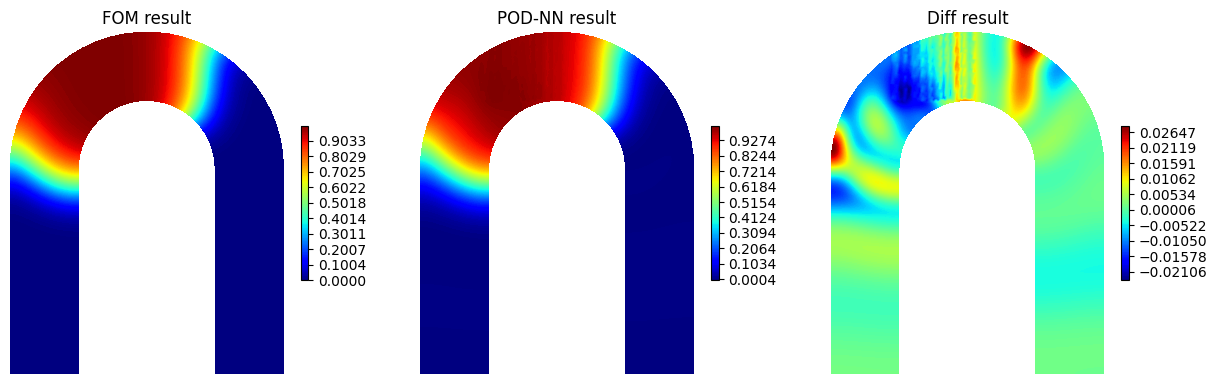

In [ ]:
# let's look at the results
timeInstance = 160
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2)  # 1 row, 2 columns, position 1
fe.plot(model(mut[timeInstance].cpu().numpy())@ V.T, Vh, colorbar=True, shrink=0.4)
plt.title("POD-NN result")

plt.subplot(1, 3, 1)  # 1 row, 2 columns, position 1
fe.plot(u[timeInstance],Vh, colorbar=True, shrink=0.4)
plt.title("FOM result")
print(f"for mut: {mut[timeInstance].cpu().numpy()}")

plt.subplot(1, 3, 3)  # 1 row, 2 columns, position 1
fe.plot(u[timeInstance]-model(mut[timeInstance].cpu().numpy())@ V.T,Vh, colorbar=True, shrink=0.4)
plt.title("Diff result")
print(f"for mut: {mut[timeInstance].cpu().numpy()}")

### Load L2 error function

In [ ]:
l2 = L2(Vh)
if cuda: # check for cuda
    l2.cuda()
clc()

def error(utrue, upred):
    return (l2(utrue-upred).reshape(-1, ntimes).sum(axis = -1)/l2(utrue).reshape(-1, ntimes).sum(axis = -1)).mean()

## **Error comparison**

In [ ]:
uROM = model(mut[ntrain:].cpu().numpy()) @ V.T
print("Average relative error of POD-NN: %s." % num2p(mre(euclidean)(u[ntrain:].cpu(), uROM)))

if cuda:
  model.cuda()
# if not cuda add/remove .cuda() and dv.tensor()
L2Error_PODNN = error(u[ntrain:], model(mut[ntrain:]) @ dv.tensor(V).T)
print("POD-NN MRE: %s" % num2p(L2Error_PODNN))
if L2Error_PODNN < 0.1:
    print("ROM result is satisfactory!")
else:
    print("more training needed!")

Average relative error of POD-NN: 5.87%.
POD-NN MRE: 4.82%
ROM result is satisfactory!


/tmp/ipython-input-230-1140243634.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  u_pred = model(mut[:]) @ V.T


u_pred shape: torch.Size([4100, 6636])
u_pred shape: torch.Size([100, 41, 6636])


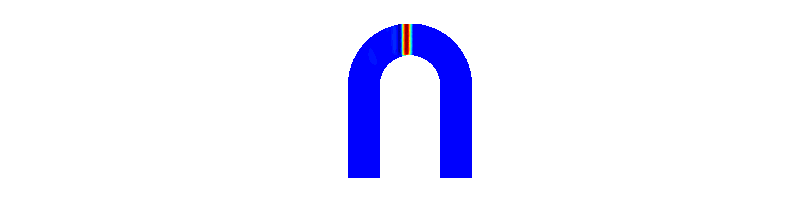

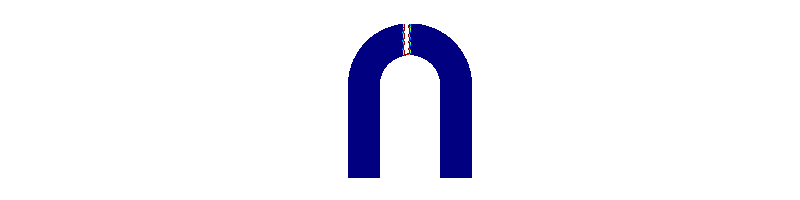

In [ ]:
u_pred = model(mut[:]) @ V.T
print(f"u_pred shape: {u_pred.shape}") # in this output each row is just one picture at one timestep
# reshpe to get a specific simulation for all 41 timesteps
u_pred = u_pred.reshape(-1, ntimes, nh)
print(f"u_pred shape: {u_pred.shape}")

visualize(u_pred[20]) # pick some simulation randomly for example trajectory 20

utrue = u.reshape(-1, ntimes, nh) # reshape ground truth and compare
visualize(utrue[20])

mu_temp shape: torch.Size([41, 4])


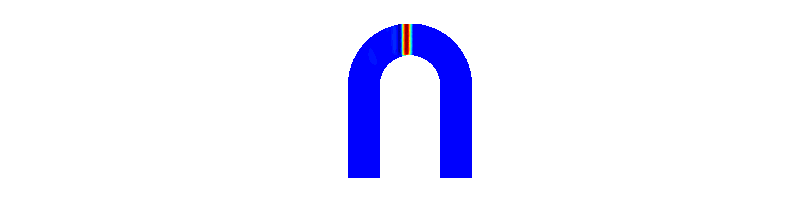

In [ ]:
# reshape the mut to initial 100,41,4
# then take one sample of 41,4 instead of all 4100,4
mu_temp = mut.reshape(-1, ntimes, p+1)
mu_temp = mu_temp[20]
print(f"mu_temp shape: {mu_temp.shape}")

# !cd /kaggle/working # change directory to store gif file
visualize(model(mu_temp) @ dv.tensor(V).T)

In [ ]:
def ROMSolver(model,mu_temp,V):
  return model(mu_temp) @ dv.tensor(V).T

dtFOM = 19.33 # time for FOM solver, in seconds for 41 timestep
t0 = perf_counter()
ROMSolver(model,mu_temp,V)
t1 = perf_counter()
dtROM = t1-t0


t0 = perf_counter()
mu_aux = torch.cat((mut, mut)) # auxiliary tensor with 200 different parameter configurations each 41 timestep
ROMSolver(model,mu_aux,V)
t1 = perf_counter()
dtROM200 = t1-t0
print("for one trajectory...")
print("FOM solver:\t1 call = %.2f ms" % (1000*dtFOM))
print("POD-NN solver:\t1 call = %.2f ms" % (1000*dtROM))
print("\n")
print("for 200 trajectory...")
print("FOM solver:\t200 calls = %.2f min" % (200*dtFOM/60.0))
print("POD-NN solver:\t200 calls = %.2f s" % dtROM200)

for one trajectory...
FOM solver:	1 call = 19330.00 ms
POD-NN solver:	1 call = 3.67 ms


for 200 trajectory...
FOM solver:	200 calls = 64.43 min
POD-NN solver:	200 calls = 0.31 s


# **DL-ROMS**

## **Training AE + phi networks simultanously**

In [ ]:
#@title Model Architecture
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
split = 75
ntrain = split*ntimes
# Latent space dimension
latent_dim = 9

class CustomActivation(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.activation_fn = activation_fn

    def forward(self, x):
        return self.activation_fn(x)
rho_e = lambda x: nn.functional.tanh(x) * 0.1
rho_d = lambda x: nn.functional.relu(x) - 0.1 * nn.functional.relu(-x)

# Encoder
encoder = nn.Sequential(
    nn.Linear(nh, 512),
    CustomActivation(rho_e),
    nn.Linear(512, 64),
    CustomActivation(rho_e),
    nn.Linear(64, latent_dim),
    CustomActivation(rho_e)
)

# Decoder
decoder = nn.Sequential(
    nn.Linear(latent_dim, 256),
    CustomActivation(rho_d),
    nn.Linear(256, 512),
    CustomActivation(rho_d),
    nn.Linear(512, nh)
)

# Phi network (DFNN for dynamics)
# Note: Input is p+1 (3 params + 1 time)
phi_network = nn.Sequential(
    nn.Linear(p + 1, 512),
    nn.GELU(),
    nn.Linear(512, 128),
    nn.GELU(),
    nn.Linear(128, latent_dim)
)

# Move models to GPU if available
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()
    phi_network.cuda()
    u = u.cuda()
    mut = mut.cuda()

**To load pre-trained models (all encoder decoder phi networks)**

In [ ]:
#@title load pre-trained models
# to load the saved models
all_params = list(encoder.parameters()) + list(decoder.parameters()) + list(phi_network.parameters())
optimizer = Adam(all_params, lr=1e-4)

MODEL_CHECKPOINT_PATH = "dl_rom_checkpoint_v5.pth"

checkpoint = torch.load(MODEL_CHECKPOINT_PATH,map_location=torch.device('cpu'))

encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
phi_network.load_state_dict(checkpoint['phi_network_state_dict'])
# To resume training, you would also load the optimizer state:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print("Models loaded successfully from a single checkpoint file.")

Models loaded successfully from a single checkpoint file.


**Define the hyper-parameters**

In [ ]:
#@title Define the hyper-parameters
# --- 2. Setup Optimizer and DataLoader ---

# Combine all parameters for the optimizer
all_params = list(encoder.parameters()) + list(decoder.parameters()) + list(phi_network.parameters())
optimizer = Adam(all_params, lr=5e-5)

# L2 loss function from your notebook (or use nn.MSELoss)
# def error(utrue, upred): ...
loss_fn = nn.MSELoss() # Simpler to use PyTorch's built-in MSE

# Create datasets and dataloaders for training and validation
batch_size = 64

# Training data
u_train = u[:ntrain]
mut_train = mut[:ntrain]
train_dataset = TensorDataset(u_train, mut_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation data
u_val = u[ntrain:]
mut_val = mut[ntrain:]
val_dataset = TensorDataset(u_val, mut_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

**Training Loop**

In [ ]:
#@title Training Loop
# --- 3. The Simultaneous Training Loop ---

epochs = 200 # @param

for epoch in range(epochs):
    # --- Training Phase ---
    # AE = DFNN(encoder+decoder)
    encoder.train()
    decoder.train()
    phi_network.train()

    train_loss = 0.0
    for u_batch, mut_batch in train_loader:

        # Zero the gradients
        optimizer.zero_grad()

        # === FORWARD PASS ===
        # Path 1: Get the "true" latent representation
        latent_true = encoder(u_batch)

        # Path 2: Get the predicted latent representation
        latent_pred = phi_network(mut_batch)

        # Path 3: Reconstruct the solution from the predicted latent state
        u_reconstructed = decoder(latent_pred)

        # === CALCULATE LOSSES ===
        # L_int: Loss in the latent space
        loss_int = loss_fn(latent_pred, latent_true)

        # L_rec: Loss in the high-dimensional space
        loss_rec = loss_fn(u_reconstructed, u_batch)

        # Total loss
        total_loss = loss_rec + loss_int

        # === BACKWARD PASS & OPTIMIZE ===
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # --- Validation Phase ---
    encoder.eval()
    decoder.eval()
    phi_network.eval()

    val_loss = 0.0
    with torch.no_grad():
        for u_batch_val, mut_batch_val in val_loader:
            latent_true_val = encoder(u_batch_val)
            latent_pred_val = phi_network(mut_batch_val)
            u_reconstructed_val = decoder(latent_pred_val)

            loss_int_val = loss_fn(latent_pred_val, latent_true_val)
            loss_rec_val = loss_fn(u_reconstructed_val, u_batch_val)

            total_val_loss = loss_rec_val + loss_int_val
            val_loss += total_val_loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

Epoch 1/200 | Train Loss: 0.000057 | Val Loss: 0.000226
Epoch 2/200 | Train Loss: 0.000053 | Val Loss: 0.000227
Epoch 3/200 | Train Loss: 0.000052 | Val Loss: 0.000228
Epoch 4/200 | Train Loss: 0.000052 | Val Loss: 0.000223
Epoch 5/200 | Train Loss: 0.000053 | Val Loss: 0.000222
Epoch 6/200 | Train Loss: 0.000052 | Val Loss: 0.000229
Epoch 7/200 | Train Loss: 0.000052 | Val Loss: 0.000225
Epoch 8/200 | Train Loss: 0.000052 | Val Loss: 0.000227
Epoch 9/200 | Train Loss: 0.000052 | Val Loss: 0.000228
Epoch 10/200 | Train Loss: 0.000052 | Val Loss: 0.000228
Epoch 11/200 | Train Loss: 0.000052 | Val Loss: 0.000225
Epoch 12/200 | Train Loss: 0.000052 | Val Loss: 0.000226
Epoch 13/200 | Train Loss: 0.000052 | Val Loss: 0.000224
Epoch 14/200 | Train Loss: 0.000054 | Val Loss: 0.000230
Epoch 15/200 | Train Loss: 0.000053 | Val Loss: 0.000227
Epoch 16/200 | Train Loss: 0.000052 | Val Loss: 0.000225
Epoch 17/200 | Train Loss: 0.000052 | Val Loss: 0.000226
Epoch 18/200 | Train Loss: 0.000053 | Va

### *side note*: AE model latent dimension study

In [ ]:
#@title L2 Load

if torch.cuda.is_available():
    print("CUDA is available!")
    cuda = True
else:
    print("CUDA not available")
    cuda = False

l2 = L2(Vh)
if cuda: # check for cuda
    l2.cuda()
clc()

def error(utrue, upred):
    return (l2(utrue-upred).reshape(-1, ntimes).sum(axis = -1)/l2(utrue).reshape(-1, ntimes).sum(axis = -1)).mean()

In [ ]:
#@title AE arcitecture train\load
def train(lat_num,epochs,u):
  # check if cuda is available for usage
  if torch.cuda.is_available():
      print("CUDA is available!")
      cuda = True
  else:
      print("CUDA not available")
      cuda = False

  split = 75
  ntrain = split*ntimes

  from torch.optim import Adam
  rho_e = lambda x: relu(x) -0.5*relu(-x)
  rho_d = lambda x: relu(x) -0.5*relu(-x)


  latent = lat_num
  encoder = Dense(nh, 128, rho_e) + Dense(128, latent, rho_e)
  decoder = Dense(latent, 128, rho_d) + Dense(128, nh, activation = None)
  autoencoder = DFNN(encoder + decoder)
  autoencoder.He()


  if cuda: # check for cuda
      autoencoder.cuda()
      u = dv.tensor(u)

  if load_pretrained:
      MODEL_SAVE_PATH_state_dict = "my_AE_state_dict4-81.pth"
      autoencoder.load_state_dict(torch.load(MODEL_SAVE_PATH_state_dict,weights_only=False))
      autoencoder.freeze()
      print("Model loaded from pretrained weights.")
      print(autoencoder)

  if retrain:
    autoencoder.unfreeze()
    autoencoder.train(u, u, ntrain = ntrain, epochs = epochs, loss = mse(l2),
                      error = error, notation = '%')

    # autoencoder.train(u, u, ntrain = ntrain, epochs = 100, loss = mse(l2),
    #                   optim = Adam, lr = 1e-6, batchsize = 64,
    #                   error = error, notation = '%')
    autoencoder.freeze()

  print("Autoencoder MRE: %s" % num2p(error(u[ntrain:].cuda(), autoencoder(u[ntrain:].cuda()))))
  return error(u[ntrain:].cuda(), autoencoder(u[ntrain:].cuda())), autoencoder, encoder, decoder

In [ ]:
outList = []
for pp in range(p+1, 2*(p+1)+1):
  outList.append(train(pp,30,u))

		Train	Test
Epoch 30:	9.51%	9.74%.

>> ETA: 1.36s.

Training complete. Elapsed time: 40.81 seconds.
Autoencoder MRE: 9.74%


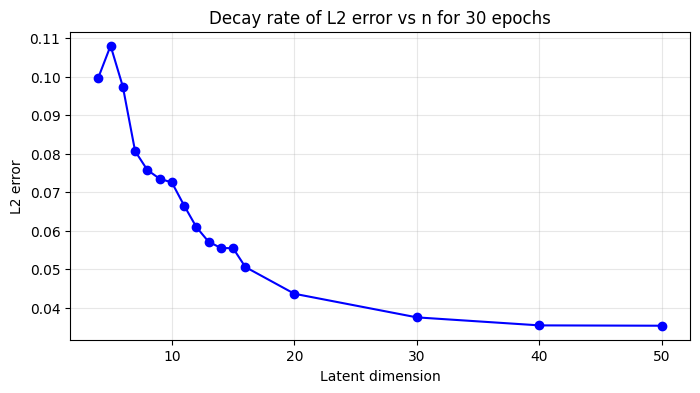

In [ ]:
values = [tensor.cpu().item() for tensor in outList]
ind = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 30, 40, 50]

# Create plot
plt.figure(figsize=(8, 4))
plt.plot(ind,values, marker='o', linestyle='-', color='b')
plt.xlabel('Latent dimension')
plt.ylabel('L2 error')
plt.title('Decay rate of L2 error vs n for 30 epochs')
plt.grid(alpha=0.3)

**Note**: While the optimal latent dimension for an autoencoder is typically found through hyperparameter tuning, theoretical results provide strong guidance. For a problem with p parameters, the Kolmogorov nonlinear n-width suggests that the minimal required latent dimension, n_min, is bounded by p ≤ n_min ≤ 2p + 1. In our U-bolt problem with p=3 (p=4 including time) parameters, this implies a theoretical optimal dimension between 3(4) and 7(9). This justifies our search for a latent dimension in this low range (n=7 or 9), which is drastically smaller than the n=80 dimensions required by a linear POD method, highlighting the compression advantage of nonlinear ROMs.

In [ ]:
err, autoencoder, encoder, decoder = train(25,150,u)

		Train	Test
Epoch 150:	2.13%	2.35%.

>> ETA: 1.36s.

Training complete. Elapsed time: 3 minutes 24.48 seconds.
Autoencoder MRE: 2.35%


## **Results**

In [ ]:
#@title L2 definition

if torch.cuda.is_available():
    print("CUDA is available!")
    cuda = True
else:
    print("CUDA not available")
    cuda = False

l2 = L2(Vh)
if cuda: # check for cuda
    l2.cuda()
clc()

def error(utrue, upred):
    return (l2(utrue-upred).reshape(-1, ntimes).sum(axis = -1)/l2(utrue).reshape(-1, ntimes).sum(axis = -1)).mean()

In [ ]:
#@title Error Comparison
autoencoder = DFNN(encoder + decoder)
split = 75
ntrain = split*ntimes
# Error comparison of AE and with same dimension if POD were used.
# if not cuda remove .cuda()
if torch.cuda.is_available():
  print("Autoencoder MRE: %s" % num2p(error(u[ntrain:].cuda(), autoencoder(u[ntrain:].cuda()))))
else:
  print("Autoencoder MRE: %s" % num2p(error(u[ntrain:], autoencoder(u[ntrain:]))))

# V = dv.tensor(X[: , :latent])
# print("POD MRE: %s" % num2p(error(u[ntrain:].cuda(), u[ntrain:].cuda() @ V @ V.T)))

Autoencoder MRE: 4.02%


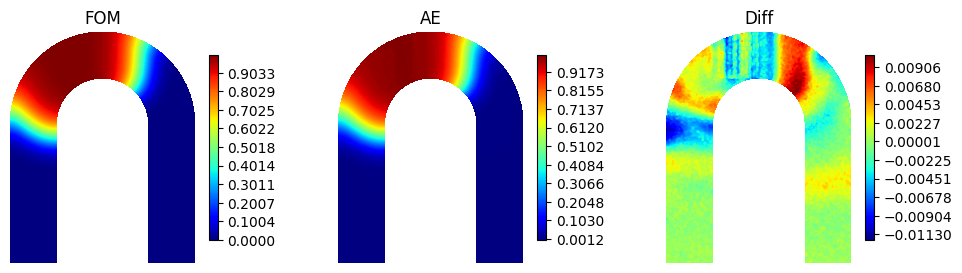

In [ ]:
#@title side note: Visual verification of AE and FOM
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1), fe.plot(u[160],Vh, colorbar=True, shrink=0.8) , plt.title("FOM")
if torch.cuda.is_available():
  plt.subplot(1,3,2), fe.plot(autoencoder(u[160].cuda()),Vh, colorbar=True, shrink=0.8), plt.title("AE")

  plt.subplot(1,3,3), fe.plot(u[160].cuda() - autoencoder(u[160].cuda()),Vh, colorbar=True, shrink=0.8), plt.title("Diff")

else:
  plt.subplot(1,3,2), fe.plot(autoencoder(u[160]),Vh, colorbar=True, shrink=0.8), plt.title("AE")

  plt.subplot(1,3,3), fe.plot(u[160] - autoencoder(u[160]),Vh, colorbar=True, shrink=0.8), plt.title("Diff")

In [ ]:
#@title To Save the checkpoint
save = True # @param {"type":"boolean"}
if save:
  MODEL_CHECKPOINT_PATH = "dl_rom_checkpoint_v5.pth" # @param
  # After the training loop finishes...
  print("Training complete. Saving model checkpoint...")

  torch.save({
      'encoder_state_dict': encoder.state_dict(),
      'decoder_state_dict': decoder.state_dict(),
      'phi_network_state_dict': phi_network.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(), # Optional: save optimizer state
      'epoch': epoch, # Optional: save the last epoch number
  }, MODEL_CHECKPOINT_PATH)

  print(f"Model checkpoint saved to {MODEL_CHECKPOINT_PATH}")

Training complete. Saving model checkpoint...
Model checkpoint saved to dl_rom_checkpoint_v5.pth


### Phi model (just for comaprison)

In [ ]:
#@title Load/Train Options
load_pretrained = False # @param {"type":"boolean"}
retrain = True # @param {"type":"boolean"}

In [ ]:
#@title Phi architecture train\load
def trainPhi(latent,epochs,u,mut,size):
  if cuda:
    nu = encoder(u.cuda())
  else:
    nu = encoder(u)

  from dlroms.dnns import Fourier
  fmodes = 20
  phi = DFNN(Dense(p+1, size, gelu) + Dense(size, size, gelu) + Dense(size, latent, activation = None))

  phi.He()

  if cuda: # check for cuda
      phi.cuda()

  if load_pretrained:
      MODEL_SAVE_PATH_state_dict = "phi_model_state_dict-10-20.pth"
      phi.load_state_dict(torch.load(MODEL_SAVE_PATH_state_dict,weights_only=False))
      phi.freeze()
      print("Model loaded from pretrained weights.")
      print(phi)

  if retrain:
    phi.unfreeze()
    phi.train(mut, nu, ntrain = ntrain, epochs = epochs, loss = mse(euclidean))
    # phi.train(mut, nu, ntrain = ntrain, epochs = 10000, loss = mse(euclidean),
    #                 optim = Adam, lr = 6e-5, batchsize = 2048)
    phi.freeze()
  dlrom = lambda mt: decoder(phi(mt))
  return error(u[ntrain:].cuda(), dlrom(mut[ntrain:])), phi

In [ ]:
def reTrain(model,inp, outp, epochs):
    model.unfreeze()
    model.train(mut, nu, ntrain = ntrain, epochs = epochs, loss = mse(euclidean))
    # phi.train(mut, nu, ntrain = ntrain, epochs = 10000, loss = mse(euclidean),
    #                 optim = Adam, lr = 6e-5, batchsize = 2048)
    model.freeze()
    return model

In [ ]:
err,phi = trainPhi(25,30,u,mut,1028)

		Train		Test
Epoch 30:	4.52e+01	6.50e+01.

>> ETA: 0.54s.

Training complete. Elapsed time: 16.41 seconds.


In [ ]:
if cuda:
    nu = encoder(u.cuda())
else:
    nu = encoder(u)

phi = reTrain(phi, mut, nu, 100)

		Train		Test
Epoch 100:	4.95e+00	1.29e+01.

>> ETA: 0.58s.

Training complete. Elapsed time: 57.61 seconds.


## **DL-ROM error**

In [ ]:
#@title DL-ROM error
# dlrom = lambda mt: decoder(phi(mt))
dlrom = lambda mt: decoder(phi_network(mt))
if torch.cuda.is_available():
  print(num2p(error(u[ntrain:].cuda(), dlrom(mut[ntrain:]))))
else:
  print(num2p(error(u[ntrain:], dlrom(mut[ntrain:]))))

2.78%


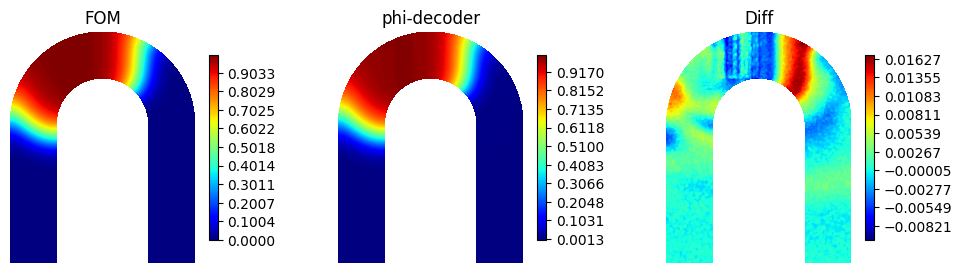

In [ ]:
#@title Visual verification
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1), fe.plot(u[160],Vh, colorbar=True, shrink=0.8) , plt.title("FOM")
if torch.cuda.is_available():
  plt.subplot(1,3,2), fe.plot(dlrom(mut[160:161]).squeeze(),Vh, colorbar=True, shrink=0.8), plt.title("phi-decoder")

  plt.subplot(1,3,3), fe.plot(u[160].cuda() - dlrom(mut[160:161]).squeeze(),Vh, colorbar=True, shrink=0.8), plt.title("Diff")
else:
  plt.subplot(1,3,2), fe.plot(dlrom(mut[160:161]).squeeze(),Vh, colorbar=True, shrink=0.8), plt.title("phi-decoder")

  plt.subplot(1,3,3), fe.plot(u[160] - dlrom(mut[160:161]).squeeze(),Vh, colorbar=True, shrink=0.8), plt.title("Diff")

# plt.savefig("my_figurezx.png")

In [ ]:
#@title Fancy colormap for plotting
from matplotlib.colors import ListedColormap
import matplotlib as mpl
jet = mpl.colormaps['jet']
jet_colors = jet(np.linspace(0, 1, 256))
def modify_jet_to_gray(jet_colors):
    new_colors = jet_colors.copy()
    gray_vals = np.linspace(0.3, 0.7, 85)
    for i in range(85):
        new_colors[i, 0:3] = gray_vals[i]
    return ListedColormap(new_colors)
gray_jet = modify_jet_to_gray(jet_colors)

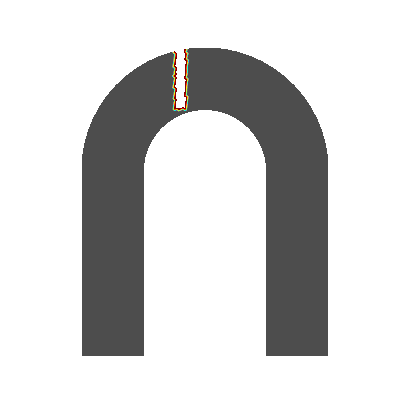

In [ ]:
# First simulation in the dataset
mu_base, u_base = dv.tensor(dataset['mu']), dv.tensor(dataset['u'])

fe.animate(u_base[0,:41], Vh, cmap = gray_jet)

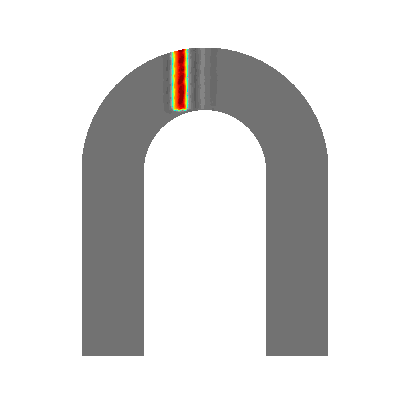

In [ ]:
nm = 0
fe.animate(dlrom(mut[nm*41:(nm+1)*41]).squeeze(), Vh, cmap = gray_jet)

# Part iii) and iv)

In [ ]:
from dlroms.minns import Integral
_, u_truth = dataset['mu'], dataset['u']
u_truth = dv.tensor(u_truth)
ns, nt, nh = u_truth.shape

space_integral = Integral(Vh)
clc()

def J(u):
  return space_integral(u).reshape(-1, nt).mean(axis = -1)

# if cuda remove .cpu()
J(u_truth.cpu()).shape # Values of the functional J (see task (iii) - (iv)) across the dataset

torch.Size([100])

## **POD-NN part**

In [ ]:
#POD-NN
def Jrom(u):
    return space_integral(u @ dv.tensor(V).T).reshape(-1, nt).mean(axis = -1)
Jrom(model_podNN(mut)).shape  # Values of the functional J (see task (iii) - (iv)) across the dataset

torch.Size([100])

In [ ]:
# reform to get parameters for first jnum trajectories
jnum = 100  # Number of trajectories to consider
mut_test = mut.reshape(-1, nt, p+1)[:jnum]  # Parameters for the dataset
u_test = model_podNN(mut_test) @ dv.tensor(V).T  # ROM solution for the parameters
u_test.shape  # Shape of the ROM solution


torch.Size([100, 41, 6636])

Functional J values for the first three simulations:


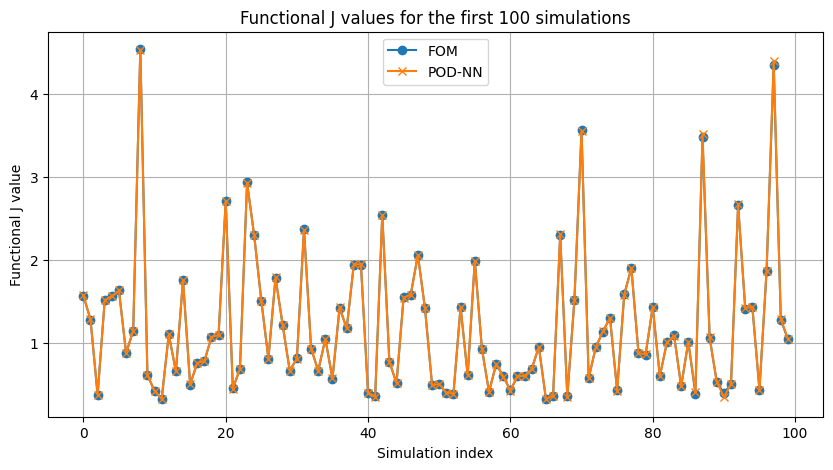

In [ ]:
# compare the values of the functional J for the first three simulations
print("Functional J values for the first three simulations:")
J(u_truth[:jnum]) , Jrom(model_podNN(mut_test))# Values of the functional J on the first, second and third simulation

# plot the values of the functional J for the first three simulations
plt.figure(figsize = (10, 5))
plt.plot(J(u_truth[:jnum]), label = 'FOM', marker = 'o')
plt.plot(Jrom(model_podNN(mut_test)), label = 'POD-NN', marker = 'x')
plt.xlabel('Simulation index')
plt.ylabel('Functional J value')
plt.title(f'Functional J values for the first {jnum} simulations')
plt.legend()
plt.grid()
plt.show()


In [ ]:
J(u_truth[:jnum]) - Jrom(model_podNN(mut_test))

(torch.Size([100]), torch.Size([100]))

In [ ]:
v_true = J(u_truth[:jnum])
v_pred = Jrom(model_podNN(mut_test))
# Calculate the L2 norm of the difference (the absolute error)
diff_norm = torch.linalg.norm(v_pred - v_true)

# Calculate the L2 norm of the true vector
true_norm = torch.linalg.norm(v_true)

# Calculate the relative L2 error
relative_l2_error = diff_norm / true_norm

# To prevent division by zero if v_true could be a zero vector
# relative_l2_error = diff_norm / (true_norm + 1e-8)

print(f"Absolute L2 Error (Norm of difference): {diff_norm.item():.6f}")
print(f"Norm of True Vector: {true_norm.item():.6f}")
print(f"Relative L2 Error: {relative_l2_error.item():.6f}")
print(f"Relative L2 Error (as percentage): {relative_l2_error.item() * 100:.2f}%")

Absolute L2 Error (Norm of difference): 0.089876
Norm of True Vector: 14.601632
Relative L2 Error: 0.006155
Relative L2 Error (as percentage): 0.62%


In [ ]:
r = np.linspace(100,1000,1000)
sigma = np.array([1, 1.5, 2])

mu1 = 0.5
mu2 = np.log(r) - 2
mu3 = sigma - 1
t = mut_test[1,:,3]

In [ ]:
mut_iv = np.zeros((ntimes, 4))
Jrom_list = np.zeros((mu3.shape[0], r.shape[0]))
mut_iv[:, 0] = mu1
for j in range(mu3.shape[0]):
    for ii in range(r.shape[0]):

        mut_iv[:, 1] = mu2[ii]
        mut_iv[:, 2] = mu3[j]
        mut_iv[:, 3] = t
        Jrom_list[j, ii] = Jrom(model_podNN(dv.tensor(mut_iv)))

/tmp/ipython-input-39-1561764376.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  mut_iv[:, 3] = t


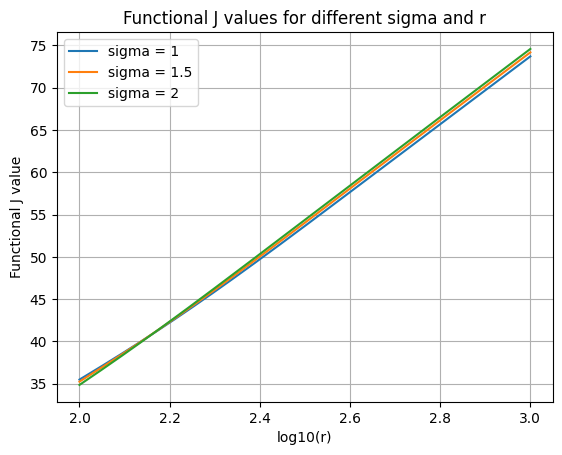

In [ ]:
plt.plot(np.log10(r), Jrom_list[0,:], label='sigma = 1')
plt.plot(np.log10(r), Jrom_list[1,:], label='sigma = 1.5')
plt.plot(np.log10(r), Jrom_list[2,:], label='sigma = 2')
plt.xlabel('log10(r)')
plt.ylabel('Functional J value')
plt.title('Functional J values for different sigma and r')
plt.legend()
plt.grid()
plt.show()

## **DL-ROM Part**

In [ ]:
# reform to get parameters for first jnum trajectories
jnum = 100  # Number of trajectories to consider
mut_test = mut.reshape(-1, nt, p+1)[:jnum]  # Parameters for the dataset
u_test = dlrom(mut_test.reshape(-1,4))  # ROM solution for the parameters
u_test.shape  # Shape of the ROM solution


torch.Size([4100, 6636])

In [ ]:
# compare the values of the functional J for the first three simulations
print("Functional J values for the first three simulations:")
J(u_truth[:jnum].cpu()) , J(dlrom(mut_test.reshape(-1,4)).reshape(-1,nt,nh).cpu())# Values of the functional J on the first, second and third simulation

Functional J values for the first three simulations:


(tensor([1.5723, 1.2846, 0.3781, 1.5171, 1.5703, 1.6358, 0.8823, 1.1494, 4.5331,
         0.6182, 0.4263, 0.3301, 1.1079, 0.6607, 1.7601, 0.5037, 0.7645, 0.7849,
         1.0716, 1.1043, 2.7067, 0.4568, 0.6895, 2.9323, 2.2959, 1.5126, 0.8136,
         1.7891, 1.2181, 0.6689, 0.8176, 2.3715, 0.9367, 0.6693, 1.0539, 0.5731,
         1.4253, 1.1783, 1.9447, 1.9456, 0.3972, 0.3616, 2.5451, 0.7791, 0.5174,
         1.5588, 1.5855, 2.0630, 1.4190, 0.4975, 0.5051, 0.4034, 0.3956, 1.4352,
         0.6162, 1.9931, 0.9355, 0.4156, 0.7464, 0.6058, 0.4324, 0.6050, 0.6124,
         0.6933, 0.9575, 0.3275, 0.3716, 2.3007, 0.3628, 1.5237, 3.5594, 0.5800,
         0.9506, 1.1410, 1.3067, 0.4331, 1.5877, 1.9053, 0.8880, 0.8611, 1.4375,
         0.6037, 1.0131, 1.0979, 0.4816, 1.0168, 0.3918, 3.4769, 1.0645, 0.5342,
         0.4016, 0.5072, 2.6631, 1.4169, 1.4369, 0.4428, 1.8673, 4.3387, 1.2849,
         1.0456]),
 tensor([1.5737, 1.2851, 0.3765, 1.5180, 1.5763, 1.6439, 0.8821, 1.1491, 4.5602,
         

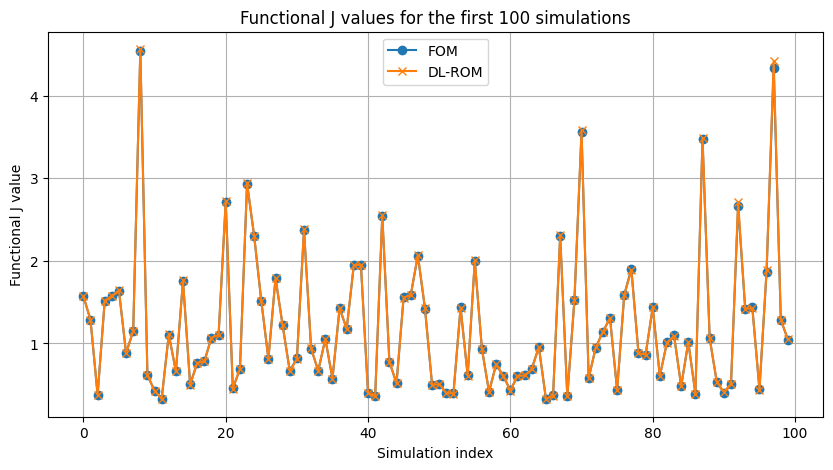

In [ ]:
# plot the values of the functional J for the first three simulations
plt.figure(figsize = (10, 5))
plt.plot(J(u_truth[:jnum].cpu()), label = 'FOM', marker = 'o')
plt.plot(J(dlrom(mut_test.reshape(-1,4)).detach().cpu()), label = 'DL-ROM', marker = 'x')
plt.xlabel('Simulation index')
plt.ylabel('Functional J value')
plt.title(f'Functional J values for the first {jnum} simulations')
plt.legend()
plt.grid()
plt.show()

# plt.savefig("my_figure1.png")

In [ ]:
v_true = J(u_truth[split:].cpu())
mut_test = mut.reshape(-1, nt, p+1)[split:]
v_pred = J(dlrom(mut_test.reshape(-1,4)).detach().cpu())
# Calculate the L2 norm of the difference (the absolute error)
diff_norm = torch.linalg.norm(v_pred - v_true)

# Calculate the L2 norm of the true vector
true_norm = torch.linalg.norm(v_true)

# Calculate the relative L2 error
relative_l2_error = diff_norm / true_norm

# To prevent division by zero if v_true could be a zero vector
# relative_l2_error = diff_norm / (true_norm + 1e-8)

print(f"Absolute L2 Error (Norm of difference): {diff_norm.item():.6f}")
print(f"Norm of True Vector: {true_norm.item():.6f}")
print(f"Relative L2 Error: {relative_l2_error.item():.6f}")
print(f"Relative L2 Error (as percentage): {relative_l2_error.item() * 100:.2f}%")

Absolute L2 Error (Norm of difference): 0.097978
Norm of True Vector: 8.018212
Relative L2 Error: 0.012219
Relative L2 Error (as percentage): 1.22%


In [ ]:
r = np.linspace(100,1000,1000)
sigma = np.array([1, 1.5, 2])

mu1 = 0.5
mu2 = np.log(r) - 2
mu3 = sigma - 1
t = mut_test[1,:,3]

In [ ]:
mut_iv = np.zeros((ntimes, 4))
JDL_list = np.zeros((mu3.shape[0], r.shape[0]))
mut_iv[:, 0] = mu1
for j in range(mu3.shape[0]):
    for ii in range(r.shape[0]):

        mut_iv[:, 1] = mu2[ii]
        mut_iv[:, 2] = mu3[j]
        mut_iv[:, 3] = t.cpu().numpy()
        JDL_list[j, ii] = J(dlrom(dv.tensor(mut_iv)).cpu())

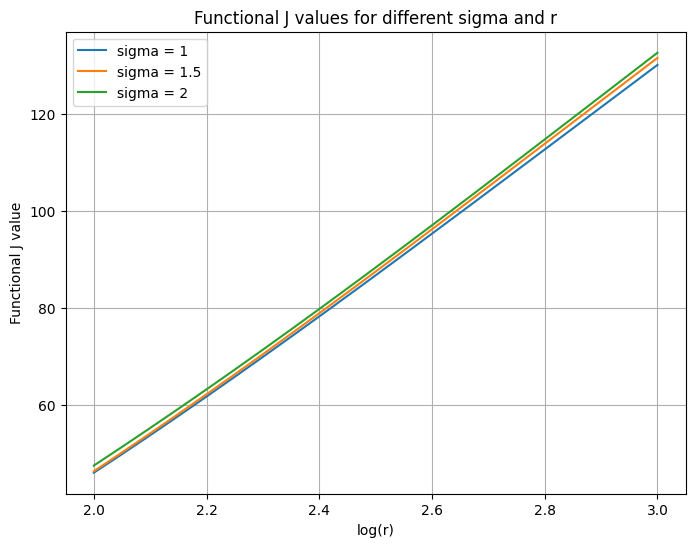

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.log10(r), JDL_list[0,:], label='sigma = 1')
plt.plot(np.log10(r), JDL_list[1,:], label='sigma = 1.5')
plt.plot(np.log10(r), JDL_list[2,:], label='sigma = 2')
# plt.xscale('log')
plt.xlabel('log(r)')
plt.ylabel('Functional J value')
plt.title('Functional J values for different sigma and r')
plt.legend()
plt.grid()


# plt.savefig("my_figure11.png")

as for the results I believe that the POD-NN performed better due to lower L2 error also the fact that the DLROM result were inconsistent by further training the plot changes and seemingly get closer and closer to the POD-NN result

DLROM persumebly requires denser network and further training which was not possible due to limited time and GPU resources  (also simoultanous training of phi and AE might improve the results)

since the DLROM error that was acheived was below 10 percent further training were halted.

the above graph only improved after increasing the latent dimension to 25, seems like lower numbers like 7 can not capture the entire solution and proper outcome for extrapolation since the mut of section iv are outside of the parameter space of the training part